## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Load and preprocess dataset

In [2]:
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df[['Adj Close']]

## Normalize the data

In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Adj Close'] = scaler.fit_transform(df[['Adj Close']])

## Prepare the data for time-series prediction

In [4]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1
data = df.values
X, y = create_dataset(data, time_steps)

## Split the data into training and testing sets

In [5]:
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Define the Echo State Network (ESN) class

In [6]:
class ESN:
    def __init__(self, n_inputs, n_reservoir, spectral_radius=0.95, sparsity=0.1, random_state=None):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.random_state = np.random.RandomState(random_state)
        self._initialize_weights()

    def _initialize_weights(self):
        self.W_in = self.random_state.uniform(-0.5, 0.5, (self.n_reservoir, self.n_inputs + 1))
        W = self.random_state.uniform(-0.5, 0.5, (self.n_reservoir, self.n_reservoir))
        W[self.random_state.rand(*W.shape) > self.sparsity] = 0
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)

    def _quantum_feature_map(self, x):
        return np.sin(x)

    def _update_reservoir(self, state, input_signal):
        pre_activation = np.dot(self.W_in, np.hstack((1, input_signal))) + np.dot(self.W, state)
        return (1 - self.leak_rate) * state + self.leak_rate * np.tanh(pre_activation)

    def fit(self, X, y, leak_rate=0.3):
        self.leak_rate = leak_rate
        states = np.zeros((X.shape[0], self.n_reservoir))
        state = np.zeros(self.n_reservoir)
        for t in range(X.shape[0]):
            state = self._update_reservoir(state, X[t])
            states[t] = self._quantum_feature_map(state)
        self.model = Ridge(alpha=0.5)
        self.model.fit(states, y)

    def predict(self, X):
        states = np.zeros((X.shape[0], self.n_reservoir))
        state = np.zeros(self.n_reservoir)
        for t in range(X.shape[0]):
            state = self._update_reservoir(state, X[t])
            states[t] = self._quantum_feature_map(state)
        return self.model.predict(states)

## Train the ESN model

In [7]:
esn = ESN(n_inputs=time_steps, n_reservoir=300, spectral_radius=0.95, sparsity=0.1, random_state=42)
esn.fit(X_train, y_train, leak_rate=0.6)

## Make predictions

In [8]:
y_pred_train = esn.predict(X_train)
y_pred_test = esn.predict(X_test)

## Inverse transform the predictions

In [9]:
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_inv = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

## Evaluate model performance

In [10]:
train_mse = mean_squared_error(y_train_inv, y_pred_train_inv)
test_mse = mean_squared_error(y_test_inv, y_pred_test_inv)
print(f'Training MSE: {train_mse:.4f}')
print(f'Testing MSE: {test_mse:.4f}')

Training MSE: 8.4658
Testing MSE: 1773.7428


## Plot the results

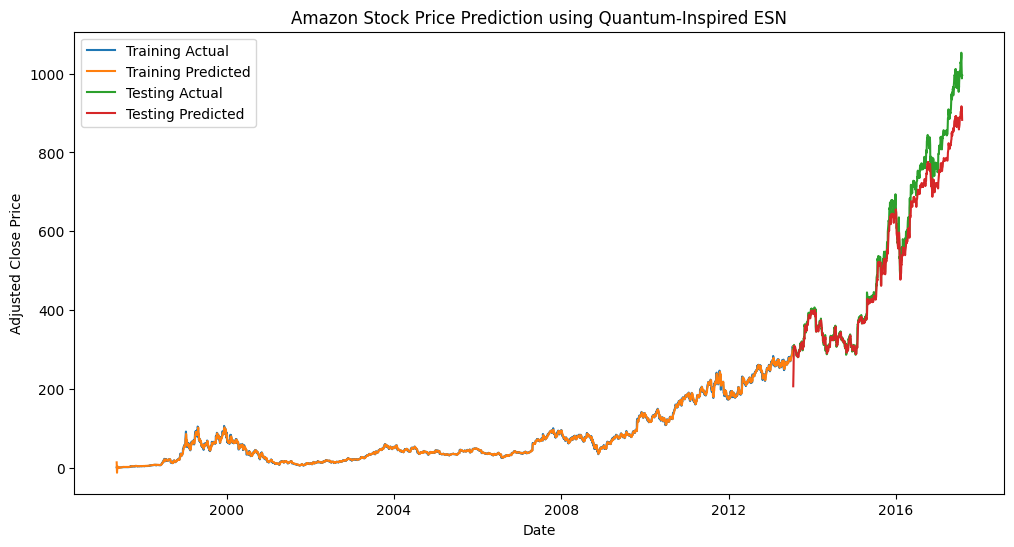

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[time_steps:train_size + time_steps], y_train_inv, label='Training Actual')
plt.plot(df.index[time_steps:train_size + time_steps], y_pred_train_inv, label='Training Predicted')
plt.plot(df.index[train_size + time_steps:], y_test_inv, label='Testing Actual')
plt.plot(df.index[train_size + time_steps:], y_pred_test_inv, label='Testing Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Amazon Stock Price Prediction using Quantum-Inspired ESN')
plt.legend()
plt.show()
